# Import Libraries

In [1]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_validate
from sklearn.metrics import matthews_corrcoef, f1_score, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.stats import mode

from xgboost import XGBClassifier

import lightgbm as lgb
from lightgbm import LGBMClassifier

# Loading Data

In [59]:
filepath = '/Users/no.2/Desktop/GitHub/kaggle_mushroom/playground-series-s4e8/'
train_df = pd.read_csv(filepath+'train.csv', index_col='id')
orig_df = pd.read_csv(filepath+'secondary_data.csv', sep=";")
test_df = pd.read_csv(filepath+'test.csv', index_col='id')

In [6]:
# orig 기준 category value
cat_feature = orig_df.select_dtypes(exclude=np.number).columns.drop('class').tolist()

cat_dic = {}
for i in cat_feature:
    cat_dic[i] = orig_df[i].unique()

In [4]:
# data cleaning
from tqdm import tqdm
for column, valid_values in tqdm(cat_dic.items()):
    train_df[column] = train_df[column].apply(lambda x: x if x in valid_values else np.nan)
    test_df[column] = test_df[column].apply(lambda x: x if x in valid_values else np.nan)

 12%|█▏        | 2/17 [00:26<03:20, 13.34s/it]


KeyboardInterrupt: 

In [3]:
train_df = pd.concat([train_df, orig_df], ignore_index=True)

In [4]:
train_df.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,e,8.80,f,s,u,f,a,c,w,4.51,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,p,4.51,x,h,o,f,a,c,n,4.79,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,e,6.94,f,s,b,f,x,c,w,6.85,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,e,3.88,f,y,g,f,s,NaN,g,4.16,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,e,5.85,x,l,w,f,d,NaN,w,3.37,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


# EDA

In [8]:
pd.DataFrame({
    'column': train_df.columns,
    'null-count': train_df.isna().sum().values,
    '% null-count': np.round(train_df.isna().sum().values*100/len(train_df),6)
}).sort_values(by='null-count', ascending=False).reset_index(drop=True)

,column,null-count,% null-count
0,veil-type,3015464,94.885170
1,spore-print-color,2904571,91.395790
2,stem-root,2808744,88.380479
3,veil-color,2794744,87.939952
4,stem-surface,2019381,63.542231
5,gill-spacing,1283642,40.391326
6,cap-surface,685745,21.577784
7,gill-attachment,534321,16.813047
8,ring-type,131751,4.145702
9,cap-shape,567,0.017841


In [60]:
train_df.duplicated().sum()

0

In [61]:
train_df.drop_duplicates(inplace=True)

In [62]:
target = 'class'

In [63]:
features = train_df.drop(target, axis=1).columns.to_list()
features

['cap-diameter',
 'cap-shape',
 'cap-surface',
 'cap-color',
 'does-bruise-or-bleed',
 'gill-attachment',
 'gill-spacing',
 'gill-color',
 'stem-height',
 'stem-width',
 'stem-root',
 'stem-surface',
 'stem-color',
 'veil-type',
 'veil-color',
 'has-ring',
 'ring-type',
 'spore-print-color',
 'habitat',
 'season']

In [64]:
features_with_high_null_values = [feature for feature in features if (train_df[feature].isna().sum()/len(train_df)*100)>20]
features_with_high_null_values

['cap-surface',
 'gill-spacing',
 'stem-root',
 'stem-surface',
 'veil-type',
 'veil-color',
 'spore-print-color']

In [52]:
categorical_features = train_df[features].select_dtypes(include='object').columns.to_list()
categorical_features

['cap-shape',
 'cap-surface',
 'cap-color',
 'does-bruise-or-bleed',
 'gill-attachment',
 'gill-spacing',
 'gill-color',
 'stem-root',
 'stem-surface',
 'stem-color',
 'veil-type',
 'veil-color',
 'has-ring',
 'ring-type',
 'spore-print-color',
 'habitat',
 'season']

In [65]:
numerical_features = list(set(features) - set(categorical_features))
numerical_features

['stem-width', 'stem-height', 'cap-diameter']

In [16]:
pd.concat([train_df, test_df])[categorical_features].describe(include='O').T

,count,unique,top,freq
cap-shape,5254895,7,x,2420906
cap-surface,4122792,11,t,775813
cap-color,5255182,12,n,2288052
does-bruise-or-bleed,5255638,2,f,4333736
gill-attachment,4371396,7,a,1089690
gill-spacing,3132511,3,c,2242712
gill-color,5255010,12,w,1570803
stem-root,608965,5,b,279559
stem-surface,1914713,8,s,552129
stem-color,5255326,13,w,2016928


## Distribution of Categorical Features

In [71]:
train_p_df = train_df[train_df[target] == 'p']
train_e_df = train_df[train_df[target] == 'e']

KeyboardInterrupt: 

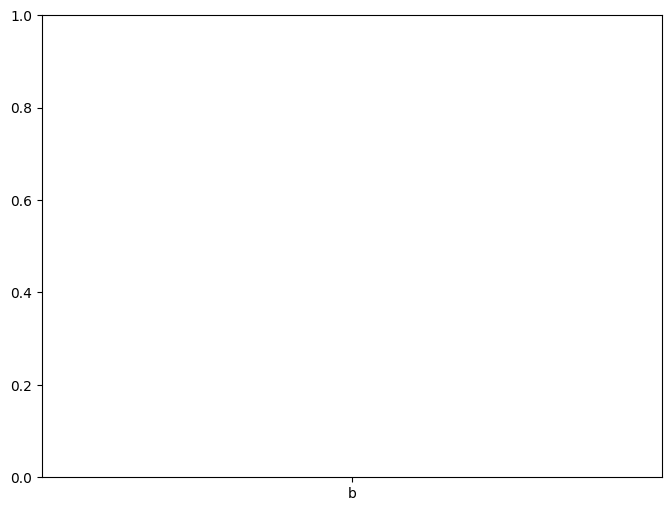

In [72]:
for i, col in enumerate(categorical_features):
    plt.figure(figsize=(8, 6))

    # fil_data = train_df[col].value_counts()
    # # fil_cat = fil_data[fil_data>=100].index
    # fil_df = train_df[train_df[col].isin(fil_cat)]

    sns.countplot(x=col, hue=target, data=train_df)

    plt.title(f"Count Plot of {col}", size=20)
    plt.show()

In [ ]:
plt.figure(figsize=(8, 15))
for i, col in enumerate(numerical_features):
    plt.subplot(3, 1, i+1)
    sns.histplot(x=col, hue=target, data=train_df, kde=True, bins=20)
    plt.title(f"Histogram of {col}", size=20)
    sns.despine()
plt.tight_layout()
plt.suptitle("Distribution of Numerical Features", y=1.05, size=28)
plt.show()

In [ ]:
plt.figure(figsize=(8, 15))
for i, col in enumerate(numerical_features):
    plt.subplot(3, 1, i+1)
    sns.boxplot(x=col, y=target, hue=target, data=train_df)
    plt.title(f"Boxplot of {col}", size=20)
plt.tight_layout()
plt.suptitle("Boxplot of Numerical Features", y=1.05, size=28)
plt.show()

In [ ]:
plt.figure(figsize=(8, 15))
for i, col in enumerate(numerical_features):
    plt.subplot(3, 1, i+1)
    sns.violinplot(x=target, y=col, hue=target, data=train_df)
    plt.title(f"Violin Plot of {col}", size=20)
plt.tight_layout()
plt.suptitle("Violin Plots of Numerical Features", y=1.05, size=28)
plt.show()

## Target Distribution

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x=target, data=train_df)
plt.title("Target Distribution", size=28)
plt.plot()

## 시각화

<Axes: xlabel='stem-width', ylabel='Density'>

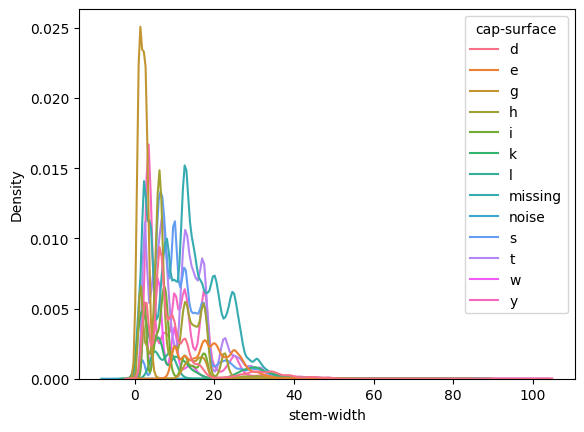

In [68]:
sns.kdeplot(x = 'stem-width', data = train_df, hue = 'cap-surface')

<Axes: xlabel='stem-width', ylabel='Density'>

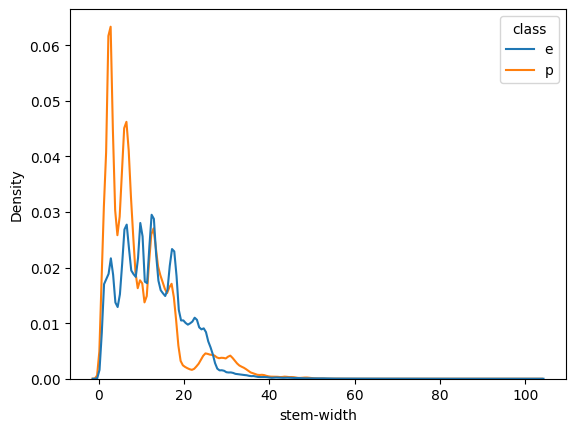

In [69]:
sns.kdeplot(x = 'stem-width', data = train_df, hue = target)

<Axes: xlabel='stem-width', ylabel='Density'>

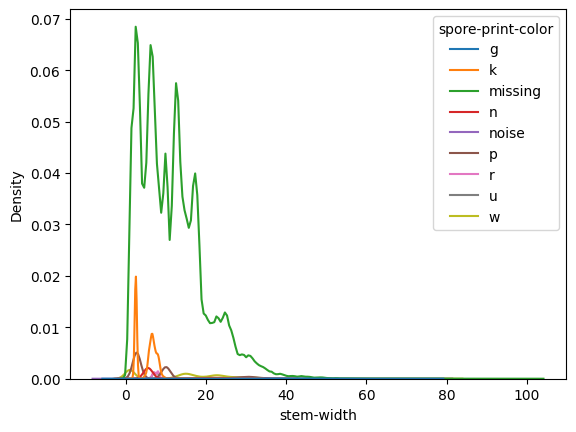

In [70]:
sns.kdeplot(x = 'stem-width', data = train_df, hue = 'spore-print-color')

# Imputing Null Values

In [66]:
# 카테고리 결측치 -> missing
# 카테고리 < 100 -> noise
def cleaner(df):
    for col in categorical_features:
        df[col] = df[col].fillna('missing')
        df.loc[df[col].value_counts(dropna=False)[df[col]].values < 100, col] = "noise"
        df[col] = df[col].astype('category')

    return df
train_df = cleaner(train_df)
test_df = cleaner(test_df)

In [67]:
# cap-diameter 결측치 -> 평균
cap_diameter_mean = pd.concat([train_df['cap-diameter'], test_df['cap-diameter']]).mean(numeric_only=True)
train_df['cap-diameter'].fillna(cap_diameter_mean, inplace=True)
test_df['cap-diameter'].fillna(cap_diameter_mean, inplace=True)

In [56]:
# count encoding
for col in categorical_features:
    count_encoding = train_df[col].value_counts()
    train_df[col] = train_df[col].map(count_encoding)
    train_df[col] = train_df[col].astype(int)
    test_df[col] = test_df[col].map(count_encoding)
    test_df[col] = test_df[col].astype(int)

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [ ]:
# 파생변수 생성
# train_df['stem_root_crf'] = [True if i in ['c', 'r'] else False for i in train_df['stem-root']]
# train_df['stem_surface_gh'] = [True if i in ['g', 'h'] else False for i in train_df['stem-surface']]
# train_df['veil_color_nkeu'] = [True if i in ['n', 'k', 'e', 'u'] else False for i in train_df['veil-color']]
# train_df['spore-print-color_knru'] = [True if i in ['k', 'n', 'r', 'u'] else False for i in train_df['spore-print-color']]
train_df['stem_width_less9'] = [True if i < 9 else False for i in train_df['stem-width']]

# test_df['stem_root_crf'] = [True if i in ['c', 'r'] else False for i in test_df['stem-root']]
# test_df['stem_surface_gh'] = [True if i in ['g', 'h'] else False for i in test_df['stem-surface']]
# test_df['veil_color_nkeu'] = [True if i in ['n', 'k', 'e', 'u'] else False for i in test_df['veil-color']]
# test_df['spore-print-color_knru'] = [True if i in ['k', 'n', 'r', 'u'] else False for i in test_df['spore-print-color']]
test_df['stem_width_less9'] = [True if i < 9 else False for i in test_df['stem-width']]

In [23]:
train_df.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season,stem_width_less9
0,e,8.80,f,s,u,f,a,c,w,4.51,...,missing,w,missing,missing,f,f,missing,d,a,False
1,p,4.51,x,h,o,f,a,c,n,4.79,...,y,o,missing,missing,t,z,missing,d,w,True
2,e,6.94,f,s,b,f,x,c,w,6.85,...,s,n,missing,missing,f,f,missing,l,w,False
3,e,3.88,f,y,g,f,s,missing,g,4.16,...,missing,w,missing,missing,f,f,missing,d,u,True
4,e,5.85,x,l,w,f,d,missing,w,3.37,...,missing,w,missing,missing,f,f,missing,g,a,True


# Model Training

In [41]:
X = train_df.copy()
y = X.pop(target)

lab_enc = LabelEncoder().fit(y)
y = lab_enc.transform(y)

In [42]:
def model_report(estimator, X, y, cv=5):
    print("="*80)
    print(f"    Model: {estimator.__class__.__name__}")
    print("="*80)

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1/cv, shuffle=True, stratify=y, random_state=42)

    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"F1 Score : {f1.mean():.6f}")
    print(f"MCC Score: {mcc.mean():.6f}")

    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    plt.title("Confusion Matrix")
    plt.show()

    print()

In [43]:
imgpath = '/Users/no.2/Desktop/GitHub/kaggle_mushroom/feature_importance'
def model_trainer(model, X, y, n_splits=5, random_state=101):
    skfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    oof_probs, oof_mccs = [], []
    print("="*80)
    print(f"Training {model.__class__.__name__}")
    print("="*80, end="\n")
    for fold, (train_idx, test_idx) in enumerate(skfold.split(X, y)):
        X_train, y_train = X.iloc[train_idx, :], y[train_idx] # train 분할
        X_test, y_test = X.iloc[test_idx, :], y[test_idx] # validation 분할

        model.fit(X_train, y_train) # train 학습
        y_pred = model.predict(X_test) # validaton 예측

        mcc = matthews_corrcoef(y_pred, y_test) # validation 성능
        oof_mccs.append(mcc)
        oof_probs.append(model.predict_proba(test_df)) # test 예측
        ax = lgb.plot_importance(model, max_num_features=len(X_train.columns), importance_type='gain')
        ax.set(title=f'Feature Importance (gain)',
            xlabel='Feature Importance',
            ylabel='Features')
        ax.figure.savefig(f'{imgpath}/fi_gain{fold}).png', dpi=300)
        print(f"--- Fold {fold+1} MCC Score: {mcc:.6f}")
    print(f"\n---> Mean MCC Score: {np.mean(oof_mccs):.6f} \xb1 {np.std(oof_mccs):.6f}\n\n")
    return oof_probs, oof_mccs

## Baseline Models

In [ ]:
xgb_clf = XGBClassifier(enable_categorical=True, device="cuda", tree_method="hist")

model_report(xgb_clf, X, y)

In [ ]:
cat_clf = CatBoostClassifier(
    cat_features=categorical_features,
    verbose=False,
    allow_writing_files=False,
    task_type="GPU"
)

model_report(cat_clf, X, y)

In [ ]:
lgb_clf = LGBMClassifier(device='gpu', verbosity=-1)

model_report(lgb_clf, X, y)

## Hyperparameter Tuning

In [ ]:
# import optuna
# from optuna.samplers import TPESampler

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, shuffle=True, stratify=y, random_state=101)

In [ ]:
# def objective(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 2000, 3000),
#         "eta": trial.suggest_float("eta", 1e-3, 1e-2),
#         "gamma": trial.suggest_float("gamma", 0, 5.0),
#         "max_depth": trial.suggest_int("max_depth", 2, 32),
#         "min_child_weight": trial.suggest_int("min_child_weight", 40, 100),
#         "subsample": trial.suggest_float("subsample", 0.1, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
#         "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
#         "max_leaves": trial.suggest_int("max_leaves", 16, 84)
#     }
#     params['device'] = 'cuda'
#     params['tree_method'] = 'hist'
#     params['enable_categorical'] = True

#     model = XGBClassifier(**params)
#     model.fit(X_train, y_train)

#     y_pred = model.predict(X_test)
#     return matthews_corrcoef(y_test, y_pred)


# study_name = "xgb"
# storage = "sqlite:///xgb.db"

# study = optuna.create_study(storage=storage,
#                             study_name=study_name,
#                             direction="maximize",
# #                             sampler=TPESampler(),
#                             load_if_exists=True)

# study.optimize(objective, n_trials=100)

# print(study.best_params)


In [ ]:
# def objective(trial):
#     params = {
#         "iterations": trial.suggest_int("iterations", 100, 3000),
#         "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
#         "depth": trial.suggest_int("depth", 4, 10),
#         "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
#         "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
#         "random_strength": trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
#         "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 10.0),
#         "od_type": trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
#         "od_wait": trial.suggest_int("od_wait", 10, 50),
#         "verbose": False,
#         "allow_writing_files": False,
#         "task_type": 'GPU',
#         "cat_features": categorical_features
#     }

#     model = CatBoostClassifier(**params)

#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     return matthews_corrcoef(y_test, y_pred)


# study_name = "cat"
# storage = "sqlite:///cat.db"

# study = optuna.create_study(storage=storage,
#                             study_name=study_name,
#                             direction="maximize",
#                             sampler=TPESampler(n_startup_trials=20, multivariate=True),
#                             load_if_exists=True)

# study.optimize(objective, n_trials=50)

# print(study.best_params)

In [ ]:
# def objective(trial):
#     params = {
#         "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
#         "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 256),
#         "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
#         "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
#         "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
#         "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
#         "device": 'gpu',
#         "verbosity": -1
#     }

#     model = LGBMClassifier(**params)

#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     return matthews_corrcoef(y_test, y_pred)


# study_name = "lgb"
# storage = "sqlite:///lgb.db"

# study = optuna.create_study(storage=storage,
#                             study_name=study_name,
#                             direction="maximize",
#                             sampler=TPESampler(n_startup_trials=20, multivariate=True),
#                             load_if_exists=True)

# study.optimize(objective, n_trials=100)

# print(study.best_params)

In [44]:
xgb_params = {
    'n_estimators': 2407,
    'eta': 0.009462133032592785,
    'gamma': 0.2865859948765318,
    'max_depth': 31,
    'min_child_weight': 47,
    'subsample': 0.6956431754146083,
    'colsample_bytree': 0.3670732604094118,
    'grow_policy': 'lossguide',
    'max_leaves': 73,
    'enable_categorical': True,
    'n_jobs': -1,
    'device': 'cuda',
    'tree_method': 'hist'
} # 0.9844272567086021

cat_params = {
    'iterations': 1041,
    'learning_rate': 0.08777255350163136,
    'depth': 10,
    'l2_leaf_reg': 0.1259643500248322,
    'bootstrap_type': 'Bayesian',
    'random_strength': 4.276181166674371e-08,
    'bagging_temperature': 0.35995482350907326,
    'od_type': 'Iter',
    'od_wait': 39,
    "verbose": False,
    "allow_writing_files": False,
    "task_type": 'GPU',
    "cat_features": categorical_features
} # 0.9841773055825763

lgb_params = {
    'n_estimators': 2500,
    'random_state':42,
    'max_bin':1024,
    'colsample_bytree':0.6,
    'reg_lambda': 80,
#     'device': 'gpu',
    'verbosity': -1
}

## Prediction

In [57]:
oof_probs = {}
# oof_probs['xgb'], _ = model_trainer(XGBClassifier(**xgb_params), X, y, random_state=101)
# oof_probs['cat'], _ = model_trainer(CatBoostClassifier(**cat_params), X, y, random_state=101)
oof_probs['lgb'], _ = model_trainer(LGBMClassifier(**lgb_params), X, y, random_state=101)

Training LGBMClassifier


ValueError: train and valid dataset categorical_feature do not match.

In [29]:
oof_preds = {}
for model in oof_probs.keys():
    oof_preds[model] = np.argmax(np.mean(oof_probs[model], axis=0), axis=1)

# Submission

In [51]:
# 전체 데이터 기반
sub = pd.read_csv("/Users/no.2/Desktop/mush/playground-series-s4e8/sample_submission.csv")
model = LGBMClassifier(**lgb_params)
model.fit(X, y)
pred = model.predict(test_df)
print('done!')
# target 변환 및 csv 생성
sub[target] = lab_enc.inverse_transform(pred)
sub.to_csv("submission.csv", index=False)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/no.2/Desktop/mush/playground-series-s4e8/sample_submission.csv'

In [30]:
# oof 기반 
# 넘버링 수정
numbering = 'less9'
sub = pd.read_csv("/Users/no.2/Desktop/GitHub/kaggle_mushroom/playground-series-s4e8/sample_submission.csv")
preds = [pred for model, pred in oof_preds.items()]
md = mode(preds, axis=0)[0] if len(preds)>1 else preds[0]
sub[target] = lab_enc.inverse_transform(md)
sub.to_csv(f"/Users/no.2/Desktop/GitHub/kaggle_mushroom/submission/submission_{numbering}.csv", index=False)